In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [18]:
class BasicNet(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.linear1 = nn.Linear(32*32*3, 1000)
        self.linear2 = nn.Linear(1000, 1000)
        self.linear3 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.softmax(x)

        return x

class BasicDropoutNet(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.drop1 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(32*32*3, 1000)
        self.drop2 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(1000, 1000)
        self.drop3 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = self.drop1(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.drop2(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.drop3(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.softmax(x)

        return x

In [19]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 200
lr = 0.001

In [20]:
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root="CIFAR10", download=True, train=True, transform=transformations)
val_data = datasets.CIFAR10(root="CIFAR10", download=True, train=False, transform=transformations)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
def train(model, dataloader, optimizer, device="cpu"):
    
    # store loss & accuracy for each epoch
    total_loss = 0.0
    total = 0.0
    correct = 0.0

    model.train()

    for images, labels in dataloader:

        # send stuff to device
        images, labels = images.to(device), labels.to(device)

        # forward pass
        preds = model(images)

        # compute loss with L2-regularization
        loss = loss_fn(preds, labels)

        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

        # gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss and accuracy calculations
        total_loss += preds.shape[0] * loss.item()
        _, predicted = torch.max(preds.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
                
    train_loss = total_loss / total
    train_accuracy = correct / total

    print(f"[Training] Loss: {train_loss}, Accuracy: {train_accuracy}")
    
    return train_loss, train_accuracy

In [22]:
def validate(model, dataloader, device="cpu"):
    
    # store loss & accuracy for each epoch
    total_loss = 0.0
    total = 0.0
    correct = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:

            # send stuff to device
            images, labels = images.to(device), labels.to(device)

            # forward pass
            preds = model(images)

            # compute loss
            loss = loss_fn(preds, labels)

            # loss and accuracy calculations
            total_loss += preds.shape[0] * loss.item()
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
    val_loss = total_loss / total
    val_accuracy = correct / total

    print(f"[Validation] Loss: {val_loss}, Accuracy: {val_accuracy}")

    return val_loss, val_accuracy

# AdaGrad

## L2 Only

In [23]:
adagrad_L2_train_loss = []
adagrad_L2_validation_loss = []
adagrad_L2_train_accuracy = []
adagrad_L2_validation_accuracy = []

In [24]:
model = BasicNet().to(device)
adagrad_optimizer = optim.Adagrad(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adagrad_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adagrad_L2_train_loss.append(train_loss)
    adagrad_L2_validation_loss.append(val_loss)
    adagrad_L2_train_accuracy.append(train_acc)
    adagrad_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.3125114086914063, Accuracy: 0.35748
[Validation] Epoch: 0
[Validation] Loss: 2.064680142593384, Accuracy: 0.4042
[Training] Epoch: 1
[Training] Loss: 2.172159332809448, Accuracy: 0.41068
[Validation] Epoch: 1
[Validation] Loss: 2.048800601196289, Accuracy: 0.4174
[Training] Epoch: 2
[Training] Loss: 2.134578538894653, Accuracy: 0.43142
[Validation] Epoch: 2
[Validation] Loss: 2.035703549194336, Accuracy: 0.4357
[Training] Epoch: 3
[Training] Loss: 2.112889401626587, Accuracy: 0.44746
[Validation] Epoch: 3
[Validation] Loss: 2.0284442180633544, Accuracy: 0.4415
[Training] Epoch: 4
[Training] Loss: 2.099012758407593, Accuracy: 0.45662
[Validation] Epoch: 4
[Validation] Loss: 2.0222469741821287, Accuracy: 0.4494
[Training] Epoch: 5
[Training] Loss: 2.0885195255279543, Accuracy: 0.4662
[Validation] Epoch: 5
[Validation] Loss: 2.0185894504547117, Accuracy: 0.4522
[Training] Epoch: 6
[Training] Loss: 2.080273957672119, Ac

## L2 + Dropout

In [25]:
adagrad_L2D_train_loss = []
adagrad_L2D_validation_loss = []
adagrad_L2D_train_accuracy = []
adagrad_L2D_validation_accuracy = []

In [26]:
model = BasicDropoutNet().to(device)
adagrad_optimizer = optim.Adagrad(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adagrad_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adagrad_L2D_train_loss.append(train_loss)
    adagrad_L2D_validation_loss.append(val_loss)
    adagrad_L2D_train_accuracy.append(train_acc)
    adagrad_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.4200131285095217, Accuracy: 0.31236
[Validation] Epoch: 0
[Validation] Loss: 2.110218046569824, Accuracy: 0.353
[Training] Epoch: 1
[Training] Loss: 2.2762511544036865, Accuracy: 0.3554
[Validation] Epoch: 1
[Validation] Loss: 2.085474835586548, Accuracy: 0.3837
[Training] Epoch: 2
[Training] Loss: 2.222351790084839, Accuracy: 0.38308
[Validation] Epoch: 2
[Validation] Loss: 2.067485859680176, Accuracy: 0.4001
[Training] Epoch: 3
[Training] Loss: 2.192630316696167, Accuracy: 0.39534
[Validation] Epoch: 3
[Validation] Loss: 2.0593214973449707, Accuracy: 0.408
[Training] Epoch: 4
[Training] Loss: 2.172971717376709, Accuracy: 0.4054
[Validation] Epoch: 4
[Validation] Loss: 2.0529550342559815, Accuracy: 0.4155
[Training] Epoch: 5
[Training] Loss: 2.1604838121032715, Accuracy: 0.41104
[Validation] Epoch: 5
[Validation] Loss: 2.050139772796631, Accuracy: 0.4163
[Training] Epoch: 6
[Training] Loss: 2.1501320083618163, Accu

# RMSProp

In [27]:
rmsprop_L2_train_loss = []
rmsprop_L2_validation_loss = []
rmsprop_L2_train_accuracy = []
rmsprop_L2_validation_accuracy = []

In [28]:
model = BasicNet().to(device)
rmsp_optimizer = optim.RMSprop(model.parameters(), lr=lr)

print(f"[Started Training with RMSProp]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, rmsp_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)
    
    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    rmsprop_L2_train_loss.append(train_loss)
    rmsprop_L2_validation_loss.append(val_loss)
    rmsprop_L2_train_accuracy.append(train_acc)
    rmsprop_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with RMSProp]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with RMSProp]
[Training] Epoch: 0
[Training] Loss: 2.25217757850647, Accuracy: 0.26482
[Validation] Epoch: 0
[Validation] Loss: 2.1157267024993898, Accuracy: 0.3353
[Training] Epoch: 1
[Training] Loss: 2.175664299850464, Accuracy: 0.3445
[Validation] Epoch: 1
[Validation] Loss: 2.1596078517913817, Accuracy: 0.2925
[Training] Epoch: 2
[Training] Loss: 2.163349464569092, Accuracy: 0.36374
[Validation] Epoch: 2
[Validation] Loss: 2.066226304626465, Accuracy: 0.3916
[Training] Epoch: 3
[Training] Loss: 2.157805859298706, Accuracy: 0.37206
[Validation] Epoch: 3
[Validation] Loss: 2.0673573749542236, Accuracy: 0.3895
[Training] Epoch: 4
[Training] Loss: 2.1499687523651123, Accuracy: 0.383
[Validation] Epoch: 4
[Validation] Loss: 2.077146003341675, Accuracy: 0.3812
[Training] Epoch: 5
[Training] Loss: 2.1434662441253662, Accuracy: 0.39098
[Validation] Epoch: 5
[Validation] Loss: 2.0996210342407227, Accuracy: 0.3557
[Training] Epoch: 6
[Training] Loss: 2.1390383824157713, Acc

In [29]:
rmsprop_L2D_train_loss = []
rmsprop_L2D_validation_loss = []
rmsprop_L2D_train_accuracy = []
rmsprop_L2D_validation_accuracy = []

In [30]:
model = BasicDropoutNet().to(device)
rmsp_optimizer = optim.RMSprop(model.parameters(), lr=lr)

print(f"[Started Training with RMSProp]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, rmsp_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    rmsprop_L2D_train_loss.append(train_loss)
    rmsprop_L2D_validation_loss.append(val_loss)
    rmsprop_L2D_train_accuracy.append(train_acc)
    rmsprop_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with RMSProp]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with RMSProp]
[Training] Epoch: 0
[Training] Loss: 2.356487551727295, Accuracy: 0.2454
[Validation] Epoch: 0
[Validation] Loss: 2.1508689041137696, Accuracy: 0.3019
[Training] Epoch: 1
[Training] Loss: 2.306620450897217, Accuracy: 0.30266
[Validation] Epoch: 1
[Validation] Loss: 2.1215370151519775, Accuracy: 0.3294
[Training] Epoch: 2
[Training] Loss: 2.3003574145507812, Accuracy: 0.31052
[Validation] Epoch: 2
[Validation] Loss: 2.118266834259033, Accuracy: 0.3375
[Training] Epoch: 3
[Training] Loss: 2.301130038986206, Accuracy: 0.31414
[Validation] Epoch: 3
[Validation] Loss: 2.122756209564209, Accuracy: 0.3307
[Training] Epoch: 4
[Training] Loss: 2.3087850171661377, Accuracy: 0.3134
[Validation] Epoch: 4
[Validation] Loss: 2.165757556152344, Accuracy: 0.2902
[Training] Epoch: 5
[Training] Loss: 2.308614891204834, Accuracy: 0.31254
[Validation] Epoch: 5
[Validation] Loss: 2.127174494171143, Accuracy: 0.3254
[Training] Epoch: 6
[Training] Loss: 2.306433290634155, Accu

# Adam+Nesterov instead of RMSProp+Nesterov

In [31]:
nadam_L2_train_loss = []
nadam_L2_validation_loss = []
nadam_L2_train_accuracy = []
nadam_L2_validation_accuracy = []

In [32]:
model = BasicNet().to(device)
nadam_optimizer = optim.NAdam(model.parameters(), lr=lr)

print(f"[Started Training with Adam+Nesterov]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, nadam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    nadam_L2_train_loss.append(train_loss)
    nadam_L2_validation_loss.append(val_loss)
    nadam_L2_train_accuracy.append(train_acc)
    nadam_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with Adam+Nesterov]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with Adam+Nesterov]
[Training] Epoch: 0
[Training] Loss: 2.231214747543335, Accuracy: 0.31454
[Validation] Epoch: 0
[Validation] Loss: 2.1005032814025877, Accuracy: 0.3556
[Training] Epoch: 1
[Training] Loss: 2.1683457498168943, Accuracy: 0.3595
[Validation] Epoch: 1
[Validation] Loss: 2.088645698547363, Accuracy: 0.3668
[Training] Epoch: 2
[Training] Loss: 2.1537037731170656, Accuracy: 0.37878
[Validation] Epoch: 2
[Validation] Loss: 2.0734183879852295, Accuracy: 0.3831
[Training] Epoch: 3
[Training] Loss: 2.146759256515503, Accuracy: 0.39238
[Validation] Epoch: 3
[Validation] Loss: 2.068698451042175, Accuracy: 0.3883
[Training] Epoch: 4
[Training] Loss: 2.1406165554046632, Accuracy: 0.39902
[Validation] Epoch: 4
[Validation] Loss: 2.0803059066772462, Accuracy: 0.3751
[Training] Epoch: 5
[Training] Loss: 2.1319981730651856, Accuracy: 0.40974
[Validation] Epoch: 5
[Validation] Loss: 2.073604839706421, Accuracy: 0.382
[Training] Epoch: 6
[Training] Loss: 2.126322992324

In [33]:
nadam_L2D_train_loss = []
nadam_L2D_validation_loss = []
nadam_L2D_train_accuracy = []
nadam_L2D_validation_accuracy = []

In [34]:
model = BasicDropoutNet().to(device)
nadam_optimizer = optim.NAdam(model.parameters(), lr=lr)

print(f"[Started Training with Adam+Nesterov]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, nadam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)
    
    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    nadam_L2D_train_loss.append(train_loss)
    nadam_L2D_validation_loss.append(val_loss)
    nadam_L2D_train_accuracy.append(train_acc)
    nadam_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with Adam+Nesterov]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with Adam+Nesterov]
[Training] Epoch: 0
[Training] Loss: 2.34330686378479, Accuracy: 0.29928
[Validation] Epoch: 0
[Validation] Loss: 2.1397062730789185, Accuracy: 0.3132
[Training] Epoch: 1
[Training] Loss: 2.3062360012054444, Accuracy: 0.31718
[Validation] Epoch: 1
[Validation] Loss: 2.1136447288513183, Accuracy: 0.3373
[Training] Epoch: 2
[Training] Loss: 2.306551409225464, Accuracy: 0.3248
[Validation] Epoch: 2
[Validation] Loss: 2.1110321491241457, Accuracy: 0.3428
[Training] Epoch: 3
[Training] Loss: 2.3004896080017088, Accuracy: 0.32508
[Validation] Epoch: 3
[Validation] Loss: 2.130937790298462, Accuracy: 0.3189
[Training] Epoch: 4
[Training] Loss: 2.294539104232788, Accuracy: 0.32648
[Validation] Epoch: 4
[Validation] Loss: 2.1416740283966065, Accuracy: 0.3127
[Training] Epoch: 5
[Training] Loss: 2.29704870262146, Accuracy: 0.32818
[Validation] Epoch: 5
[Validation] Loss: 2.1077891780853273, Accuracy: 0.3458
[Training] Epoch: 6
[Training] Loss: 2.2990062723541

# AdaDelta

In [35]:
adadelta_L2_train_loss = []
adadelta_L2_validation_loss = []
adadelta_L2_train_accuracy = []
adadelta_L2_validation_accuracy = []

In [36]:
model = BasicNet().to(device)
adadelta_optimizer = optim.Adadelta(model.parameters(), lr=lr)

print(f"[Started Training with AdaDelta]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adadelta_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)
    
    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adadelta_L2_train_loss.append(train_loss)
    adadelta_L2_validation_loss.append(val_loss)
    adadelta_L2_train_accuracy.append(train_acc)
    adadelta_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaDelta]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaDelta]
[Training] Epoch: 0
[Training] Loss: 2.971930519256592, Accuracy: 0.11652
[Validation] Epoch: 0
[Validation] Loss: 2.302132526779175, Accuracy: 0.1213
[Training] Epoch: 1
[Training] Loss: 2.970651746368408, Accuracy: 0.12488
[Validation] Epoch: 1
[Validation] Loss: 2.30188897895813, Accuracy: 0.1276
[Training] Epoch: 2
[Training] Loss: 2.969370416793823, Accuracy: 0.13278
[Validation] Epoch: 2
[Validation] Loss: 2.3016419242858888, Accuracy: 0.1356
[Training] Epoch: 3
[Training] Loss: 2.9680880934906004, Accuracy: 0.13956
[Validation] Epoch: 3
[Validation] Loss: 2.3013919036865236, Accuracy: 0.1434
[Training] Epoch: 4
[Training] Loss: 2.966806314086914, Accuracy: 0.14634
[Validation] Epoch: 4
[Validation] Loss: 2.30114052734375, Accuracy: 0.1466
[Training] Epoch: 5
[Training] Loss: 2.96552531578064, Accuracy: 0.15136
[Validation] Epoch: 5
[Validation] Loss: 2.300887943649292, Accuracy: 0.151
[Training] Epoch: 6
[Training] Loss: 2.964244641265869, Accura

In [37]:
adadelta_L2D_train_loss = []
adadelta_L2D_validation_loss = []
adadelta_L2D_train_accuracy = []
adadelta_L2D_validation_accuracy = []

In [38]:
#  L2 + Dropout
model = BasicDropoutNet().to(device)
adadelta_optimizer = optim.Adadelta(model.parameters(), lr=lr)

print(f"[Started Training with AdaDelta]")

tarin_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adadelta_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adadelta_L2D_train_loss.append(train_loss)
    adadelta_L2D_validation_loss.append(val_loss)
    adadelta_L2D_train_accuracy.append(train_acc)
    adadelta_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaDelta]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaDelta]
[Training] Epoch: 0
[Training] Loss: 2.972553684768677, Accuracy: 0.1091
[Validation] Epoch: 0
[Validation] Loss: 2.30227357673645, Accuracy: 0.1485
[Training] Epoch: 1
[Training] Loss: 2.9713130800628664, Accuracy: 0.11416
[Validation] Epoch: 1
[Validation] Loss: 2.302084398651123, Accuracy: 0.1586
[Training] Epoch: 2
[Training] Loss: 2.970140672912598, Accuracy: 0.11946
[Validation] Epoch: 2
[Validation] Loss: 2.3018941246032716, Accuracy: 0.1658
[Training] Epoch: 3
[Training] Loss: 2.9689140578460695, Accuracy: 0.12616
[Validation] Epoch: 3
[Validation] Loss: 2.3017008014678955, Accuracy: 0.1723
[Training] Epoch: 4
[Training] Loss: 2.967776482849121, Accuracy: 0.1301
[Validation] Epoch: 4
[Validation] Loss: 2.30150479888916, Accuracy: 0.1764
[Training] Epoch: 5
[Training] Loss: 2.966512331237793, Accuracy: 0.13514
[Validation] Epoch: 5
[Validation] Loss: 2.3013068618774413, Accuracy: 0.182
[Training] Epoch: 6
[Training] Loss: 2.9653299001312257, Accu

# Adam

In [39]:
adam_L2_train_loss = []
adam_L2_validation_loss = []
adam_L2_train_accuracy = []
adam_L2_validation_accuracy = []

In [40]:
model = BasicNet().to(device)
adam_optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adam_L2_train_loss.append(train_loss)
    adam_L2_validation_loss.append(val_loss)
    adam_L2_train_accuracy.append(train_acc)
    adam_L2_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.2460907688140868, Accuracy: 0.2903
[Validation] Epoch: 0
[Validation] Loss: 2.1431783557891846, Accuracy: 0.311
[Training] Epoch: 1
[Training] Loss: 2.206095140304565, Accuracy: 0.32002
[Validation] Epoch: 1
[Validation] Loss: 2.119228798675537, Accuracy: 0.3317
[Training] Epoch: 2
[Training] Loss: 2.1853194888305665, Accuracy: 0.35084
[Validation] Epoch: 2
[Validation] Loss: 2.0970114547729493, Accuracy: 0.363
[Training] Epoch: 3
[Training] Loss: 2.166796661148071, Accuracy: 0.36768
[Validation] Epoch: 3
[Validation] Loss: 2.0714786670684813, Accuracy: 0.3845
[Training] Epoch: 4
[Training] Loss: 2.160654355621338, Accuracy: 0.37732
[Validation] Epoch: 4
[Validation] Loss: 2.0726577659606935, Accuracy: 0.3827
[Training] Epoch: 5
[Training] Loss: 2.1531171892547607, Accuracy: 0.38872
[Validation] Epoch: 5
[Validation] Loss: 2.0848733472824095, Accuracy: 0.371
[Training] Epoch: 6
[Training] Loss: 2.1485395834350585, A

In [41]:
adam_L2D_train_loss = []
adam_L2D_validation_loss = []
adam_L2D_train_accuracy = []
adam_L2D_validation_accuracy = []

In [42]:
model = BasicDropoutNet().to(device)
adam_optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"[Started Training with AdaGrad]")

train_time = 0.0
for epoch in range(epochs):

    # Training Phase
    print(f"[Training] Epoch: {epoch}")
    start = time.monotonic()
    train_loss, train_acc = train(model, train_loader, adam_optimizer, device)
    end = time.monotonic()
    train_time += (end - start)

    # Validation Phase
    print(f"[Validation] Epoch: {epoch}")
    val_loss, val_acc = validate(model, val_loader, device)

    adam_L2D_train_loss.append(train_loss)
    adam_L2D_validation_loss.append(val_loss)
    adam_L2D_train_accuracy.append(train_acc)
    adam_L2D_validation_accuracy.append(val_acc)

print(f"[Finished Training with AdaGrad]", end="\n\n")
print(f"Total Training Time: {train_time}")

[Started Training with AdaGrad]
[Training] Epoch: 0
[Training] Loss: 2.3456327074432375, Accuracy: 0.28942
[Validation] Epoch: 0
[Validation] Loss: 2.1339063274383543, Accuracy: 0.3191
[Training] Epoch: 1
[Training] Loss: 2.3141175094604494, Accuracy: 0.30978
[Validation] Epoch: 1
[Validation] Loss: 2.133437303543091, Accuracy: 0.3187
[Training] Epoch: 2
[Training] Loss: 2.3182794803619386, Accuracy: 0.30772
[Validation] Epoch: 2
[Validation] Loss: 2.1300298139572145, Accuracy: 0.3242
[Training] Epoch: 3
[Training] Loss: 2.3081135816955567, Accuracy: 0.31504
[Validation] Epoch: 3
[Validation] Loss: 2.1181259239196777, Accuracy: 0.3317
[Training] Epoch: 4
[Training] Loss: 2.3150811289215087, Accuracy: 0.31706
[Validation] Epoch: 4
[Validation] Loss: 2.1329786457061766, Accuracy: 0.3176
[Training] Epoch: 5
[Training] Loss: 2.314443435974121, Accuracy: 0.31576
[Validation] Epoch: 5
[Validation] Loss: 2.109091664505005, Accuracy: 0.3445
[Training] Epoch: 6
[Training] Loss: 2.30551809158325

# Plots

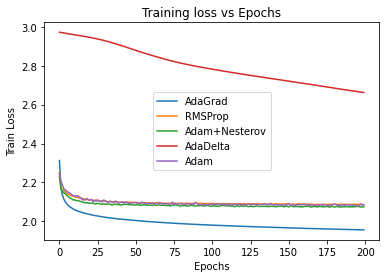

In [48]:
# Plot L2 train loss vs epochs


plt.title("Training loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.plot(range(epochs), adagrad_L2_train_loss, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2_train_loss, label="RMSProp")
plt.plot(range(epochs), nadam_L2_train_loss, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2_train_loss, label="AdaDelta")
plt.plot(range(epochs), adam_L2_train_loss, label="Adam")

plt.legend()

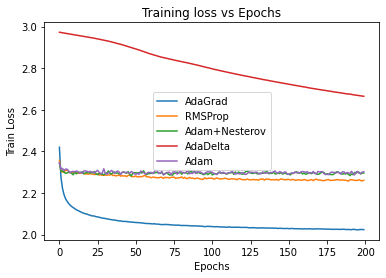

In [47]:
# Plot L2 + Dropout train loss vs epochs


plt.title("Training loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

plt.plot(range(epochs), adagrad_L2D_train_loss, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2D_train_loss, label="RMSProp")
plt.plot(range(epochs), nadam_L2D_train_loss, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2D_train_loss, label="AdaDelta")
plt.plot(range(epochs), adam_L2D_train_loss, label="Adam")
plt.legend()

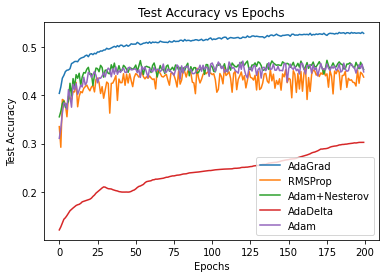

In [45]:
# Validation - Plot L2 test accuracy vs epochs


plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")

plt.plot(range(epochs), adagrad_L2_validation_accuracy, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2_validation_accuracy, label="RMSProp")
plt.plot(range(epochs), nadam_L2_validation_accuracy, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2_validation_accuracy, label="AdaDelta")
plt.plot(range(epochs), adam_L2_validation_accuracy, label="Adam")
plt.legend()

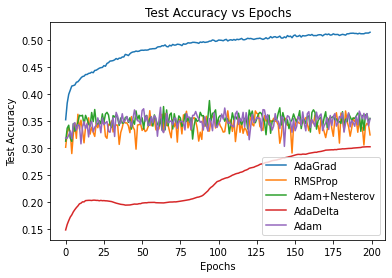

In [46]:
# Validation - Plot L2 + Dropout test accuracy vs epochs

plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")

plt.plot(range(epochs), adagrad_L2D_validation_accuracy, label="AdaGrad")
plt.plot(range(epochs), rmsprop_L2D_validation_accuracy, label="RMSProp")
plt.plot(range(epochs), nadam_L2D_validation_accuracy, label="Adam+Nesterov")
plt.plot(range(epochs), adadelta_L2D_validation_accuracy, label="AdaDelta")
plt.plot(range(epochs), adam_L2D_validation_accuracy, label="Adam")
plt.legend()